# New Section

In [ ]:
import pandas as pd
import sys
import numpy as np
from matplotlib import pyplot as plot
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences






In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Attention

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/for_train.txt", sep="\t", header=None, names=["text", "rephrase"])
print(df.head())

                                                text  \
0  You may be stressed out, but your body doesn't...   
1  Arghhh can't stand when tan goes patchy then i...   
2  M4&M49 were bloody horrendous. Finally found m...   
3  Life is just hard and harder when difficult pe...   
4  I realize you're all trying to help me, but it...   

                                            rephrase  
0  I will be able to go through stress because I ...  
1  Tanning can sometimes have unexpected results ...  
2  Even though I am facing a hard time at least I...  
3  Keep difficult people out of your life or you'...  
4  I am happy to have people who care about me an...  


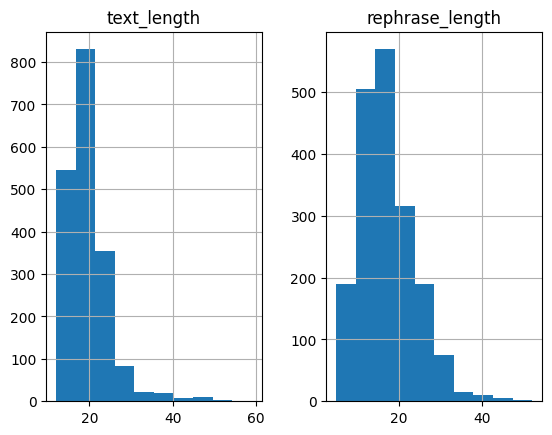

In [ ]:

def text_count():
    x_vocab = list()
    y_vocab = list()
    text_sent_length = []
    rephrase_sent_length = []
    x_word_set = []
    y_word_set = []
    for i in df['text']:
        text_sent_length.append(len(i.split()))
        x_word_set.append(i.split())
    for j in df['rephrase']:
        rephrase_sent_length.append(len(j.split()))
        y_word_set.append(j.split())
    #text_sent_length.hist()
    temp_df = pd.DataFrame({'text_length': text_sent_length, 'rephrase_length': rephrase_sent_length})
    temp_df.hist()
    plot.show()

    x_vocab = pd.Series(x_word_set).drop_duplicates().tolist()
    y_vocab = pd.Series(y_word_set).drop_duplicates().tolist()
    return x_vocab, y_vocab

x_vocab, y_vocab = text_count()


In [ ]:
len(df)

max_text_length = 30
max_rephrase_length = 30

In [ ]:
def extract_subset():
    final_text = []
    final_rephrase = []

    for i in range(len(df)):
        if(len(df["text"][i].split())<=max_text_length and len(df["rephrase"][i].split())<=max_rephrase_length):
            final_text.append(df["text"][i])
            final_rephrase.append(df["rephrase"][i])
    final_df = pd.DataFrame({"text": final_text, "rephrase": final_rephrase})
    return final_df;


In [ ]:
df = extract_subset()

def appendTokens(df):
   df['rephrase'] = df['rephrase'].apply(lambda x : '<RBEGIN> '+ x + ' <REND>')
   return df
df = appendTokens(df)
print(df.head())

                                                text  \
0  You may be stressed out, but your body doesn't...   
1  Arghhh can't stand when tan goes patchy then i...   
2  M4&M49 were bloody horrendous. Finally found m...   
3  Life is just hard and harder when difficult pe...   
4  I realize you're all trying to help me, but it...   

                                            rephrase  
0  <RBEGIN> I will be able to go through stress b...  
1  <RBEGIN> Tanning can sometimes have unexpected...  
2  <RBEGIN> Even though I am facing a hard time a...  
3  <RBEGIN> Keep difficult people out of your lif...  
4  <RBEGIN> I am happy to have people who care ab...  


In [ ]:



y_vocabulary = 0
x_vocabulary = 0
x_train_pad_sequences = ""
y_test_pad_sequences = ""
x_train, x_test, y_train, y_test = train_test_split(df['text'], df['rephrase'],
                                    test_size=0.2, random_state=42, shuffle=True)
x_tokenizer = Tokenizer(num_words=len(x_vocab) )
x_tokenizer.fit_on_texts(x_train)
x_train_sequence = x_tokenizer.texts_to_sequences(x_train)
x_test_sequence = x_tokenizer.texts_to_sequences(x_test)
x_train_pad_sequences = pad_sequences(x_train_sequence, maxlen = max_text_length , padding='post')
x_test_pad_sequences = pad_sequences(x_test_sequence, maxlen = max_text_length, padding='post')
x_vocabulary = x_tokenizer.num_words + 1;

# Rephrase tokenizer
y_tokenizer = Tokenizer(num_words=len(y_vocab) )
y_tokenizer.fit_on_texts(list(y_train))
y_train_sequence = y_tokenizer.texts_to_sequences(y_train)
y_test_sequence = y_tokenizer.texts_to_sequences(y_test)
y_train_pad_sequences = pad_sequences(y_train_sequence, maxlen = max_rephrase_length , padding='post')
y_test_pad_sequences = pad_sequences(y_test_sequence, maxlen = max_rephrase_length, padding='post')
y_vocabulary = y_tokenizer.num_words + 1;
    #return (x_vocabulary, y_vocabulary, x_train_pad_sequences, y_train_pad_sequences, x_test_pad_sequences, y_test_pad_sequences)



In [ ]:

y_train = np.array(df["text"])
y_test = np.array(df['rephrase'])
y_train[:, 1:]

IndexError: ignored

In [ ]:
y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:, 1:]

In [ ]:
from tensorflow.keras.models import Model


In [ ]:


latent_dim = 200
embedding_dim=300
encoder_inputs = Input(shape=(max_text_length,))
encoder_emb_layer =  Embedding(x_vocabulary, embedding_dim,trainable=True)(encoder_inputs)
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.1,recurrent_dropout=0.1)
encoder_output1, h1, c1 = encoder_lstm1(encoder_emb_layer)
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.1,recurrent_dropout=0.1)
encoder_outputs, h, c = encoder_lstm2(encoder_output1)
# Decoders
decoder_inputs = Input(shape=(None,))
decoder_emb_layer = Embedding(y_vocabulary, embedding_dim,trainable=True)
dec_emb = decoder_emb_layer(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.1,recurrent_dropout=0.1)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[h, c])
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
decoder_dense =  TimeDistributed(Dense(y_vocabulary, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 30, 300)              549900    ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 lstm (LSTM)                 [(None, 30, 200),            400800    ['embedding[0][0]']           
                              (None, 200),                                                    

In [ ]:

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [ ]:
y_train = y_train_pad_sequences.reshape(y_train_pad_sequences.shape[0], y_train_pad_sequences.shape[1], 1)[:,1:]
y_test = y_test_pad_sequences.reshape(y_test_pad_sequences.shape[0],y_test_pad_sequences.shape[1], 1)[:,1:]
history = model.fit([x_train_pad_sequences, y_train_pad_sequences[:,:-1]],
                     y_train,
                     epochs=10,
                     batch_size=128,
                     validation_data=([x_test_pad_sequences, y_test_pad_sequences[:,:-1]], y_test))

Epoch 1/10
11/11 [==============================] - 28s 810ms/step - loss: nan - val_loss: nan
Epoch 2/10
11/11 [==============================] - 5s 458ms/step - loss: nan - val_loss: nan
Epoch 3/10
11/11 [==============================] - 8s 705ms/step - loss: nan - val_loss: nan
Epoch 4/10
11/11 [==============================] - 6s 550ms/step - loss: nan - val_loss: nan
Epoch 5/10
11/11 [==============================] - 4s 331ms/step - loss: nan - val_loss: nan
Epoch 6/10
11/11 [==============================] - 3s 288ms/step - loss: nan - val_loss: nan
Epoch 7/10
11/11 [==============================] - 2s 218ms/step - loss: nan - val_loss: nan
Epoch 8/10
11/11 [==============================] - 6s 515ms/step - loss: nan - val_loss: nan
Epoch 9/10
11/11 [==============================] - 4s 339ms/step - loss: nan - val_loss: nan
Epoch 10/10
11/11 [==============================] - 4s 383ms/step - loss: nan - val_loss: nan


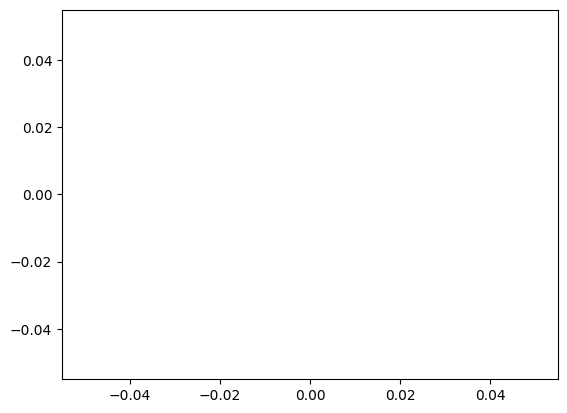

In [ ]:
val_acc = history.history["val_loss"]
plot.plot(val_acc)


https://github.com/sujanshirol/Test-Summarization-LSTMs/blob/main/NLP_Text_Summarization.ipynb

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, h, c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_length,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = decoder_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#IGNORE attention inference
# attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
# decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:

reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index
print(target_word_index['rbegin'])

2


In [ ]:

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['rbegin']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='rend'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'rend'  or len(decoded_sentence.split()) >= (max_rephrase_length-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2rephrase(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['rbegin']) and i!=target_word_index['rend']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(0, 2):
    print("Text:",seq2text(x_train_pad_sequences[i]))
    print("Original rephrase:",seq2rephrase(y_train_pad_sequences[i]))
    print("Predicted rephrase:",decode_sequence(x_train_pad_sequences[i].reshape(1,max_text_length)))
    print("\n")

Text: please call 01389298225 for all inquiries emergencies due to a phone line issue and leave a voicemail 
Original rephrase: the phone isn't working call my new number for inquiries emergencies 
1/1 [==============================] - 0s 220ms/step


KeyError: ignored